# Part 2: Classifier comparison

## Member: Yunhao CHEN 

In [13]:
import numpy as np
import pandas as pd
from scipy.io import arff
from sklearn import model_selection

from river.linear_model import LogisticRegression, PAClassifier
from river.tree import HoeffdingTreeClassifier, ExtremelyFastDecisionTreeClassifier, HoeffdingAdaptiveTreeClassifier
from river.naive_bayes import GaussianNB
from river.neighbors import KNNClassifier
from river import metrics, multiclass, utils
from river.stream import iter_pandas

import matplotlib.pyplot as plt
from tqdm import tqdm
import time

pd.set_option('display.max_columns', None)

In [2]:
data_path = "data/covtypeNorm.arff/covtypeNorm.arff"
data = arff.loadarff(data_path)
df = pd.DataFrame(data[0])
df.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,class
0,0.368684,0.141667,0.045455,0.184681,0.223514,0.071659,0.870079,0.913386,0.582677,0.875366,b'1',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'1',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'5'
1,0.365683,0.155556,0.030303,0.151754,0.215762,0.054798,0.866142,0.925197,0.594488,0.867838,b'1',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'1',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'5'
2,0.472736,0.386111,0.136364,0.191840,0.307494,0.446817,0.921260,0.937008,0.531496,0.853339,b'1',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'1',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'2'
3,0.463232,0.430556,0.272727,0.173228,0.375969,0.434172,0.937008,0.937008,0.480315,0.865886,b'1',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'1',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'2'
4,0.368184,0.125000,0.030303,0.109520,0.222222,0.054939,0.866142,0.921260,0.590551,0.860449,b'1',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'1',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'5'


In [3]:
# convert the bytes format to integer:
df.iloc[:, 10:] = df.iloc[:, 10:].apply(pd.to_numeric)

<ipython-input-3-73ba24743c0c>:2: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.iloc[:, 10:] = df.iloc[:, 10:].apply(pd.to_numeric)


In [4]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

In [8]:
def Aspect_r(x):
    if x+180>360:
        return x-180
    else:
        return x+180

def feature_engineering(X_df):
    rs_df = X_df
    rs_df['Dist_to_Hydrology'] = (rs_df['Horizontal_Distance_To_Hydrology']**2 + rs_df['Vertical_Distance_To_Hydrology']**2)**0.5
    rs_df['slope_hyd_pct1'] = rs_df['Vertical_Distance_To_Hydrology']/(rs_df['Horizontal_Distance_To_Hydrology']+0.00001)
    rs_df['slope_hyd_pct2'] = rs_df['Horizontal_Distance_To_Hydrology']/(rs_df['Vertical_Distance_To_Hydrology']+0.00001)
    rs_df['Aspect2'] = rs_df['Aspect'].map(Aspect_r)
    rs_df['Cos_slope'] = np.cos(rs_df['Slope']*2*np.pi/360)
    rs_df['Elev_m_VDH'] = rs_df['Elevation'] - rs_df['Vertical_Distance_To_Hydrology']
    rs_df['Elev_m_HDH'] = rs_df['Elevation'] - rs_df['Horizontal_Distance_To_Hydrology']*0.28
    rs_df['Mean_Hydro'] = (rs_df['Horizontal_Distance_To_Hydrology']+rs_df['Horizontal_Distance_To_Fire_Points']+rs_df['Horizontal_Distance_To_Roadways'])/3
    
    rs_df['Hydro_p_Fire'] = rs_df['Horizontal_Distance_To_Hydrology'] + rs_df['Horizontal_Distance_To_Fire_Points']
    rs_df['Hydro_m_Fire'] = rs_df['Horizontal_Distance_To_Hydrology'] - rs_df['Horizontal_Distance_To_Fire_Points']
    rs_df['Hydro_p_Road'] = rs_df['Horizontal_Distance_To_Hydrology'] + rs_df['Horizontal_Distance_To_Roadways']
    rs_df['Hydro_p_Road'] = rs_df['Horizontal_Distance_To_Hydrology'] - rs_df['Horizontal_Distance_To_Roadways']
    rs_df['Fire_p_Road'] = rs_df['Horizontal_Distance_To_Fire_Points'] + rs_df['Horizontal_Distance_To_Roadways']
    rs_df['Fire_m_Road'] = rs_df['Horizontal_Distance_To_Fire_Points'] - rs_df['Horizontal_Distance_To_Roadways']
    
    rs_df['sq_interaction_9amnoon'] = np.sqrt(rs_df['Hillshade_9am']*rs_df['Hillshade_Noon'])
    rs_df['sq_interaction_noon3pm'] = np.sqrt(rs_df['Hillshade_Noon']*rs_df['Hillshade_3pm'])
    rs_df['sq_interaction_9am3pm'] = np.sqrt(rs_df['Hillshade_9am']*rs_df['Hillshade_3pm'])
    rs_df['Mean_Hillshade'] = (rs_df['Hillshade_9am']+rs_df['Hillshade_Noon']+rs_df['Hillshade_3pm'])/3
    
    rs_df['Wilderness_Area'] = 0
    for i in range(1,5):
        rs_df['Wilderness_Area'] = rs_df['Wilderness_Area'] + i * rs_df['Wilderness_Area'+str(i)]
        rs_df = rs_df.drop("Wilderness_Area"+str(i),axis=1)
    rs_df['Wilderness_Area'] = rs_df['Wilderness_Area']**3
    
    return rs_df

In [9]:
X_featureSelect = feature_engineering(X)

In [11]:
X_train, X_test, y_train, y_test  = model_selection.train_test_split(X_featureSelect, y, test_size=0.05, random_state=1000)

In [16]:
def train(stream, model, n_wait=1000, verbose=False):
    acc = metrics.Accuracy()
    acc_rolling = utils.Rolling(metrics.Accuracy(), window_size=n_wait)
    raw_results = []
    model_name = model.__class__.__name__
    start = time.process_time()
    for i, (x, y) in tqdm(enumerate(stream), total=X_train.shape[0]):
        # Predict
        y_pred = model.predict_one(x)
        # Update metrics and results
        acc.update(y_true=y, y_pred=y_pred)
        acc_rolling.update(y_true=y, y_pred=y_pred)
        if i % n_wait == 0 and i > 0:
            raw_results.append([model_name, i, acc.get(), acc_rolling.get()])
        # Learn (train)
        model.learn_one(x, y)
    CPU_time = time.process_time() - start
    print(f'Samples processed: {i}')
    print(acc)
    print(f"CPU time : {round(CPU_time, 2)} seconds")
    return pd.DataFrame(raw_results, columns=['model', 'id', 'acc', 'acc_roll'])

In [17]:
pac = PAClassifier()

pac_results = train(stream=iter_pandas(X=X_train, y=y_train), model=pac)

100%|██████████| 551961/551961 [00:50<00:00, 11030.77it/s]

Samples processed: 551960
Accuracy: 36.47%
CPU time : 50.92 seconds


In [18]:
ht = HoeffdingTreeClassifier()

ht_results = train(stream=iter_pandas(X=X_train, y=y_train), model=ht)

100%|██████████| 551961/551961 [11:56<00:00, 769.86it/s] 

Samples processed: 551960
Accuracy: 68.20%
CPU time : 716.58 seconds


In [19]:
lr_ovs = multiclass.OneVsRestClassifier(LogisticRegression())
lr_results = train(stream=iter_pandas(X=X_train, y=y_train), model=lr_ovs)

100%|██████████| 551961/551961 [03:56<00:00, 2336.52it/s]

Samples processed: 551960
Accuracy: 43.50%
CPU time : 236.09 seconds


In [20]:
hat = HoeffdingAdaptiveTreeClassifier(split_criterion='gini')
hat_results = train(stream=iter_pandas(X=X_train, y=y_train), model=hat)

100%|██████████| 551961/551961 [31:59<00:00, 287.52it/s]  

Samples processed: 551960
Accuracy: 72.19%
CPU time : 1918.38 seconds


In [21]:
gnb = GaussianNB()
gnb_results = train(stream=iter_pandas(X=X_train, y=y_train), model=gnb)

100%|██████████| 551961/551961 [10:29<00:00, 877.07it/s]

Samples processed: 551960
Accuracy: 48.75%
CPU time : 631.3 seconds


In [79]:
# eft = ExtremelyFastDecisionTreeClassifier(split_criterion='gini')
# eft_results = train(stream=iter_pandas(X=X_train, y=y_train), model=eft)

100%|██████████| 551961/551961 [1:33:56<00:00, 97.92it/s]  

Samples processed: 551960
Accuracy: 65.16%


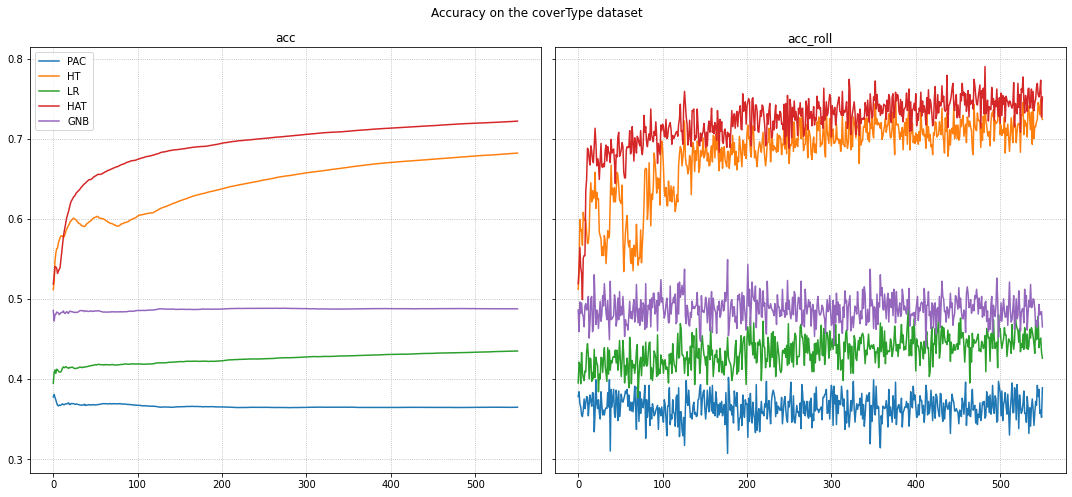

In [41]:
dataset = "coverType"

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,7), sharey=True)
for metric, ax in zip(['acc', 'acc_roll'], axes.flatten()):
    pac_results[metric].plot(title=metric, ax=ax)
    ht_results[metric].plot(title=metric, ax=ax)
    lr_results[metric].plot(title=metric, ax=ax)
    hat_results[metric].plot(title=metric, ax=ax)
    gnb_results[metric].plot(title=metric, ax=ax)
    axes[0].legend(["PAC", "HT", "LR", 'HAT', 'GNB'], loc='best')
    ax.grid(linestyle=':')
fig.suptitle("Accuracy on the %s dataset" % dataset)
plt.tight_layout()
plt.show()

In [51]:
def test(model):
    metric = metrics.Accuracy() + metrics.LogLoss()
    for xi, yi in iter_pandas(X_test, y_test):
        metric = metric.update(yi, model.predict_proba_one(xi))
    print(metric)

In [52]:
test(pac)

Accuracy: 36.27%, LogLoss: 0.12148792940619356


In [53]:
test(ht)

Accuracy: 72.57%, LogLoss: 3.6662764114867317


In [45]:
test(lr_ovs)

Accuracy: 49.16%, LogLoss: 34.516338016716354


In [46]:
test(hat)

Accuracy: 75.43%, LogLoss: 4.653709074773227


In [47]:
test(gnb)

Accuracy: 48.88%, LogLoss: 34.538776394910684


In [55]:
!jupyter nbconvert --to html Classifier_comparison.ipynb

[NbConvertApp] Converting notebook Classifier_comparison.ipynb to html
[NbConvertApp] Writing 829902 bytes to Classifier_comparison.html
